# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'
import helper

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

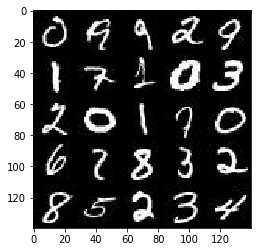

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

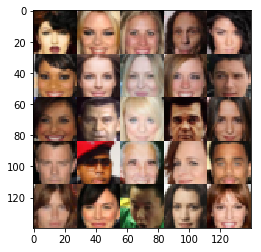

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [15]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.3
        
        # First layer: convolutional 28*28*output_channel_dim -> 14*14*64
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same') 
        x1 = tf.maximum(alpha*x1, x1)
        
        # Second layer: convolutional 7*7*128
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same') 
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)

        # Third layer: flatten then fully connected
        flat = tf.reshape(x2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [16]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.1
        
        # First layer: fully connected
        x1 = tf.layers.dense(z, 7*7*128, activation=None)
        x1 = tf.reshape(x1, (-1,7,7,128))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)

        # Second layer: convolutional transpose 14*14*64
        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)

        # Third layer: convolutional transpose 28*28*output_channel
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(\
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                            labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(\
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                            labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(\
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_loss_fake,
                                                            labels=tf.ones_like(d_loss_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)    
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    num_batches = data_shape[0] // batch_size
    
    output_channel_dim = data_shape[3]
    input_real, input_z, lr = model_inputs(*data_shape[1:3], output_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, output_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for idx, batch_images in enumerate(get_batches(batch_size)):
                steps += 1
                
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Because the value is [-0.5, 0.5]
                batch_image_real = batch_images * 2
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_image_real, 
                                                     input_z: batch_z,
                                                     lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_image_real,
                                                     input_z: batch_z,
                                                     lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_image_real, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print('Epoch {}/{}...'.format(epoch_i+1, epoch_count),
                          'Batch {}/{}...'.format(idx, num_batches),
                          'Discriminator Loss: {:.4f}...'.format(train_loss_d),
                          'Generator Loss: {:.4f}...'.format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 6, input_z, output_channel_dim, data_image_mode)              

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 9/468... Discriminator Loss: 0.9897... Generator Loss: 0.3490...
Epoch 1/2... Batch 19/468... Discriminator Loss: 0.7740... Generator Loss: 0.4203...
Epoch 1/2... Batch 29/468... Discriminator Loss: 0.4455... Generator Loss: 0.5366...
Epoch 1/2... Batch 39/468... Discriminator Loss: 0.3666... Generator Loss: 0.5779...
Epoch 1/2... Batch 49/468... Discriminator Loss: 0.4016... Generator Loss: 0.5687...
Epoch 1/2... Batch 59/468... Discriminator Loss: 0.4462... Generator Loss: 0.5663...
Epoch 1/2... Batch 69/468... Discriminator Loss: 0.5059... Generator Loss: 0.5553...
Epoch 1/2... Batch 79/468... Discriminator Loss: 0.5069... Generator Loss: 0.5545...
Epoch 1/2... Batch 89/468... Discriminator Loss: 0.4476... Generator Loss: 0.5826...
Epoch 1/2... Batch 99/468... Discriminator Loss: 0.4254... Generator Loss: 0.5719...


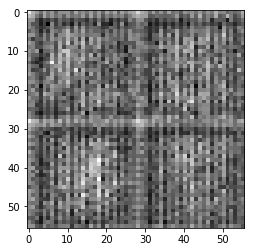

Epoch 1/2... Batch 109/468... Discriminator Loss: 0.3072... Generator Loss: 0.6190...
Epoch 1/2... Batch 119/468... Discriminator Loss: 0.2648... Generator Loss: 0.6193...
Epoch 1/2... Batch 129/468... Discriminator Loss: 0.2298... Generator Loss: 0.6392...
Epoch 1/2... Batch 139/468... Discriminator Loss: 0.2049... Generator Loss: 0.6392...
Epoch 1/2... Batch 149/468... Discriminator Loss: 0.2351... Generator Loss: 0.6316...
Epoch 1/2... Batch 159/468... Discriminator Loss: 0.3009... Generator Loss: 0.6403...
Epoch 1/2... Batch 169/468... Discriminator Loss: 0.4274... Generator Loss: 0.5294...
Epoch 1/2... Batch 179/468... Discriminator Loss: 0.3478... Generator Loss: 0.6004...
Epoch 1/2... Batch 189/468... Discriminator Loss: 0.3469... Generator Loss: 0.6459...
Epoch 1/2... Batch 199/468... Discriminator Loss: 0.3868... Generator Loss: 0.6379...


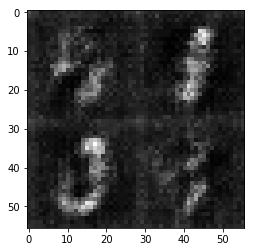

Epoch 1/2... Batch 209/468... Discriminator Loss: 0.5564... Generator Loss: 0.4863...
Epoch 1/2... Batch 219/468... Discriminator Loss: 0.7131... Generator Loss: 0.4313...
Epoch 1/2... Batch 229/468... Discriminator Loss: 0.7389... Generator Loss: 0.6483...
Epoch 1/2... Batch 239/468... Discriminator Loss: 0.7075... Generator Loss: 0.4472...
Epoch 1/2... Batch 249/468... Discriminator Loss: 0.5999... Generator Loss: 0.5354...
Epoch 1/2... Batch 259/468... Discriminator Loss: 0.6303... Generator Loss: 0.5164...
Epoch 1/2... Batch 269/468... Discriminator Loss: 0.6795... Generator Loss: 0.5932...
Epoch 1/2... Batch 279/468... Discriminator Loss: 0.7552... Generator Loss: 0.5656...
Epoch 1/2... Batch 289/468... Discriminator Loss: 0.7955... Generator Loss: 0.5764...
Epoch 1/2... Batch 299/468... Discriminator Loss: 0.7945... Generator Loss: 0.4590...


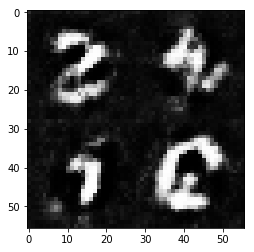

Epoch 1/2... Batch 309/468... Discriminator Loss: 0.8225... Generator Loss: 0.5925...
Epoch 1/2... Batch 319/468... Discriminator Loss: 0.7482... Generator Loss: 0.5098...
Epoch 1/2... Batch 329/468... Discriminator Loss: 0.7241... Generator Loss: 0.5088...
Epoch 1/2... Batch 339/468... Discriminator Loss: 0.8252... Generator Loss: 0.4696...
Epoch 1/2... Batch 349/468... Discriminator Loss: 0.7923... Generator Loss: 0.5706...
Epoch 1/2... Batch 359/468... Discriminator Loss: 0.7810... Generator Loss: 0.5113...
Epoch 1/2... Batch 369/468... Discriminator Loss: 0.8466... Generator Loss: 0.4637...
Epoch 1/2... Batch 379/468... Discriminator Loss: 0.8738... Generator Loss: 0.4712...
Epoch 1/2... Batch 389/468... Discriminator Loss: 0.9236... Generator Loss: 0.4142...
Epoch 1/2... Batch 399/468... Discriminator Loss: 0.9372... Generator Loss: 0.4069...


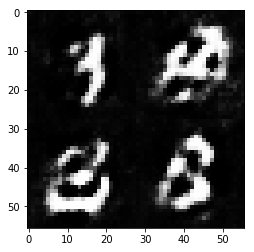

Epoch 1/2... Batch 409/468... Discriminator Loss: 0.8735... Generator Loss: 0.4984...
Epoch 1/2... Batch 419/468... Discriminator Loss: 0.9160... Generator Loss: 0.4805...
Epoch 1/2... Batch 429/468... Discriminator Loss: 0.8651... Generator Loss: 0.5149...
Epoch 1/2... Batch 439/468... Discriminator Loss: 0.8965... Generator Loss: 0.5382...
Epoch 1/2... Batch 449/468... Discriminator Loss: 0.8331... Generator Loss: 0.5205...
Epoch 1/2... Batch 459/468... Discriminator Loss: 0.8681... Generator Loss: 0.5199...
Epoch 2/2... Batch 1/468... Discriminator Loss: 0.8438... Generator Loss: 0.5490...
Epoch 2/2... Batch 11/468... Discriminator Loss: 0.8510... Generator Loss: 0.5584...
Epoch 2/2... Batch 21/468... Discriminator Loss: 0.9010... Generator Loss: 0.5370...
Epoch 2/2... Batch 31/468... Discriminator Loss: 0.9079... Generator Loss: 0.5403...


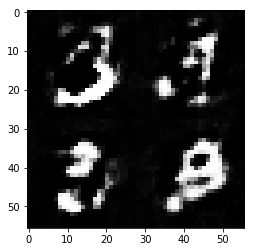

Epoch 2/2... Batch 41/468... Discriminator Loss: 0.9538... Generator Loss: 0.4004...
Epoch 2/2... Batch 51/468... Discriminator Loss: 0.8493... Generator Loss: 0.5487...
Epoch 2/2... Batch 61/468... Discriminator Loss: 0.8023... Generator Loss: 0.4932...
Epoch 2/2... Batch 71/468... Discriminator Loss: 0.8213... Generator Loss: 0.4943...
Epoch 2/2... Batch 81/468... Discriminator Loss: 0.9129... Generator Loss: 0.4373...
Epoch 2/2... Batch 91/468... Discriminator Loss: 0.9110... Generator Loss: 0.4914...
Epoch 2/2... Batch 101/468... Discriminator Loss: 1.0553... Generator Loss: 0.3580...
Epoch 2/2... Batch 111/468... Discriminator Loss: 0.8780... Generator Loss: 0.4478...
Epoch 2/2... Batch 121/468... Discriminator Loss: 0.8763... Generator Loss: 0.5405...
Epoch 2/2... Batch 131/468... Discriminator Loss: 0.8773... Generator Loss: 0.5135...


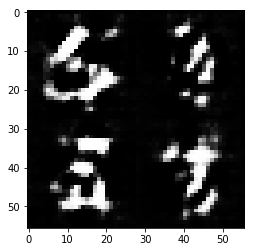

Epoch 2/2... Batch 141/468... Discriminator Loss: 0.9080... Generator Loss: 0.5556...
Epoch 2/2... Batch 151/468... Discriminator Loss: 0.9259... Generator Loss: 0.4451...
Epoch 2/2... Batch 161/468... Discriminator Loss: 0.8722... Generator Loss: 0.4988...
Epoch 2/2... Batch 171/468... Discriminator Loss: 0.8746... Generator Loss: 0.5714...
Epoch 2/2... Batch 181/468... Discriminator Loss: 0.7682... Generator Loss: 0.5590...
Epoch 2/2... Batch 191/468... Discriminator Loss: 0.9123... Generator Loss: 0.5714...
Epoch 2/2... Batch 201/468... Discriminator Loss: 0.8946... Generator Loss: 0.5721...
Epoch 2/2... Batch 211/468... Discriminator Loss: 0.8681... Generator Loss: 0.5138...
Epoch 2/2... Batch 221/468... Discriminator Loss: 0.8019... Generator Loss: 0.4842...
Epoch 2/2... Batch 231/468... Discriminator Loss: 0.7587... Generator Loss: 0.5133...


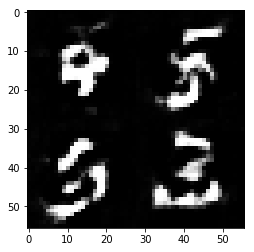

Epoch 2/2... Batch 241/468... Discriminator Loss: 0.7661... Generator Loss: 0.5362...
Epoch 2/2... Batch 251/468... Discriminator Loss: 0.7822... Generator Loss: 0.5348...
Epoch 2/2... Batch 261/468... Discriminator Loss: 0.7420... Generator Loss: 0.5050...
Epoch 2/2... Batch 271/468... Discriminator Loss: 0.7124... Generator Loss: 0.5611...
Epoch 2/2... Batch 281/468... Discriminator Loss: 0.7789... Generator Loss: 0.4883...
Epoch 2/2... Batch 291/468... Discriminator Loss: 0.7320... Generator Loss: 0.5093...
Epoch 2/2... Batch 301/468... Discriminator Loss: 0.6948... Generator Loss: 0.5239...
Epoch 2/2... Batch 311/468... Discriminator Loss: 0.7749... Generator Loss: 0.4641...
Epoch 2/2... Batch 321/468... Discriminator Loss: 0.7426... Generator Loss: 0.5742...
Epoch 2/2... Batch 331/468... Discriminator Loss: 0.7267... Generator Loss: 0.5695...


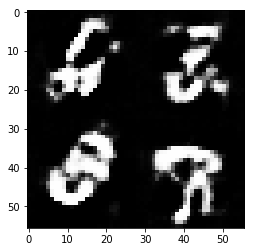

Epoch 2/2... Batch 341/468... Discriminator Loss: 0.7529... Generator Loss: 0.4973...
Epoch 2/2... Batch 351/468... Discriminator Loss: 0.7304... Generator Loss: 0.5265...
Epoch 2/2... Batch 361/468... Discriminator Loss: 0.7453... Generator Loss: 0.5638...
Epoch 2/2... Batch 371/468... Discriminator Loss: 0.7054... Generator Loss: 0.4879...
Epoch 2/2... Batch 381/468... Discriminator Loss: 0.6844... Generator Loss: 0.5141...
Epoch 2/2... Batch 391/468... Discriminator Loss: 0.6481... Generator Loss: 0.5767...
Epoch 2/2... Batch 401/468... Discriminator Loss: 0.7156... Generator Loss: 0.5407...
Epoch 2/2... Batch 411/468... Discriminator Loss: 0.7136... Generator Loss: 0.5852...
Epoch 2/2... Batch 421/468... Discriminator Loss: 0.7289... Generator Loss: 0.4911...
Epoch 2/2... Batch 431/468... Discriminator Loss: 0.7256... Generator Loss: 0.5596...


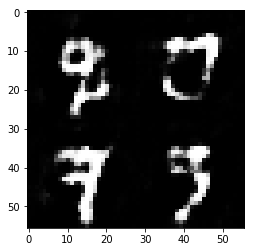

Epoch 2/2... Batch 441/468... Discriminator Loss: 0.7447... Generator Loss: 0.4978...
Epoch 2/2... Batch 451/468... Discriminator Loss: 0.7876... Generator Loss: 0.5651...
Epoch 2/2... Batch 461/468... Discriminator Loss: 0.6473... Generator Loss: 0.5556...


In [17]:
batch_size = 128
z_dim = 64
learning_rate = 0.0001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 9/1582... Discriminator Loss: 0.9579... Generator Loss: 0.3818...
Epoch 1/1... Batch 19/1582... Discriminator Loss: 0.7518... Generator Loss: 0.4492...
Epoch 1/1... Batch 29/1582... Discriminator Loss: 0.5344... Generator Loss: 0.5155...
Epoch 1/1... Batch 39/1582... Discriminator Loss: 0.3980... Generator Loss: 0.5707...
Epoch 1/1... Batch 49/1582... Discriminator Loss: 0.2936... Generator Loss: 0.6100...
Epoch 1/1... Batch 59/1582... Discriminator Loss: 0.1666... Generator Loss: 0.6441...
Epoch 1/1... Batch 69/1582... Discriminator Loss: 0.1659... Generator Loss: 0.6451...
Epoch 1/1... Batch 79/1582... Discriminator Loss: 0.1705... Generator Loss: 0.6507...
Epoch 1/1... Batch 89/1582... Discriminator Loss: 0.1246... Generator Loss: 0.6635...
Epoch 1/1... Batch 99/1582... Discriminator Loss: 0.1151... Generator Loss: 0.6603...


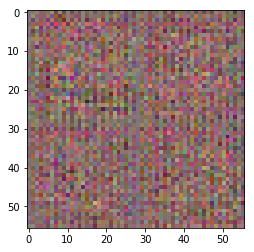

Epoch 1/1... Batch 109/1582... Discriminator Loss: 0.0947... Generator Loss: 0.6672...
Epoch 1/1... Batch 119/1582... Discriminator Loss: 0.0828... Generator Loss: 0.6730...
Epoch 1/1... Batch 129/1582... Discriminator Loss: 0.0837... Generator Loss: 0.6723...
Epoch 1/1... Batch 139/1582... Discriminator Loss: 0.0662... Generator Loss: 0.6762...
Epoch 1/1... Batch 149/1582... Discriminator Loss: 0.0635... Generator Loss: 0.6782...
Epoch 1/1... Batch 159/1582... Discriminator Loss: 0.0626... Generator Loss: 0.6775...
Epoch 1/1... Batch 169/1582... Discriminator Loss: 0.0621... Generator Loss: 0.6821...
Epoch 1/1... Batch 179/1582... Discriminator Loss: 0.0499... Generator Loss: 0.6808...
Epoch 1/1... Batch 189/1582... Discriminator Loss: 0.0404... Generator Loss: 0.6840...
Epoch 1/1... Batch 199/1582... Discriminator Loss: 0.0347... Generator Loss: 0.6848...


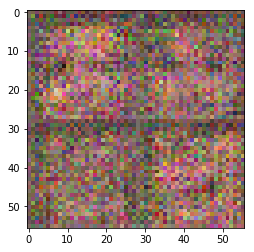

Epoch 1/1... Batch 209/1582... Discriminator Loss: 0.0395... Generator Loss: 0.6845...
Epoch 1/1... Batch 219/1582... Discriminator Loss: 0.0282... Generator Loss: 0.6857...
Epoch 1/1... Batch 229/1582... Discriminator Loss: 0.0273... Generator Loss: 0.6866...
Epoch 1/1... Batch 239/1582... Discriminator Loss: 0.0462... Generator Loss: 0.6830...
Epoch 1/1... Batch 249/1582... Discriminator Loss: 0.0351... Generator Loss: 0.6837...
Epoch 1/1... Batch 259/1582... Discriminator Loss: 0.0456... Generator Loss: 0.6808...
Epoch 1/1... Batch 269/1582... Discriminator Loss: 0.0357... Generator Loss: 0.6840...
Epoch 1/1... Batch 279/1582... Discriminator Loss: 0.0424... Generator Loss: 0.6826...
Epoch 1/1... Batch 289/1582... Discriminator Loss: 0.0346... Generator Loss: 0.6834...
Epoch 1/1... Batch 299/1582... Discriminator Loss: 0.0562... Generator Loss: 0.6795...


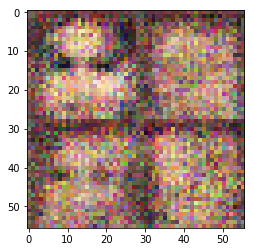

Epoch 1/1... Batch 309/1582... Discriminator Loss: 0.0620... Generator Loss: 0.6784...
Epoch 1/1... Batch 319/1582... Discriminator Loss: 0.0589... Generator Loss: 0.6809...
Epoch 1/1... Batch 329/1582... Discriminator Loss: 0.0714... Generator Loss: 0.6705...
Epoch 1/1... Batch 339/1582... Discriminator Loss: 0.2244... Generator Loss: 0.6054...
Epoch 1/1... Batch 349/1582... Discriminator Loss: 0.8357... Generator Loss: 0.3746...
Epoch 1/1... Batch 359/1582... Discriminator Loss: 0.5721... Generator Loss: 0.5446...
Epoch 1/1... Batch 369/1582... Discriminator Loss: 0.5554... Generator Loss: 0.5911...
Epoch 1/1... Batch 379/1582... Discriminator Loss: 0.4566... Generator Loss: 0.5802...
Epoch 1/1... Batch 389/1582... Discriminator Loss: 0.5128... Generator Loss: 0.5926...
Epoch 1/1... Batch 399/1582... Discriminator Loss: 0.5869... Generator Loss: 0.6284...


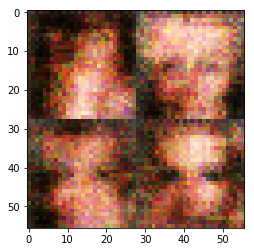

Epoch 1/1... Batch 409/1582... Discriminator Loss: 0.5195... Generator Loss: 0.5696...
Epoch 1/1... Batch 419/1582... Discriminator Loss: 0.6588... Generator Loss: 0.5876...
Epoch 1/1... Batch 429/1582... Discriminator Loss: 0.7867... Generator Loss: 0.4541...
Epoch 1/1... Batch 439/1582... Discriminator Loss: 0.6352... Generator Loss: 0.5609...
Epoch 1/1... Batch 449/1582... Discriminator Loss: 0.8283... Generator Loss: 0.5740...
Epoch 1/1... Batch 459/1582... Discriminator Loss: 0.9744... Generator Loss: 0.4821...
Epoch 1/1... Batch 469/1582... Discriminator Loss: 1.0725... Generator Loss: 0.4695...
Epoch 1/1... Batch 479/1582... Discriminator Loss: 1.2113... Generator Loss: 0.4514...
Epoch 1/1... Batch 489/1582... Discriminator Loss: 1.4310... Generator Loss: 0.6284...
Epoch 1/1... Batch 499/1582... Discriminator Loss: 1.1720... Generator Loss: 0.5422...


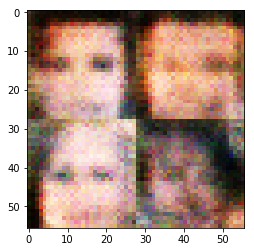

Epoch 1/1... Batch 509/1582... Discriminator Loss: 1.2407... Generator Loss: 0.4077...
Epoch 1/1... Batch 519/1582... Discriminator Loss: 1.2309... Generator Loss: 0.5487...
Epoch 1/1... Batch 529/1582... Discriminator Loss: 1.3493... Generator Loss: 0.3733...
Epoch 1/1... Batch 539/1582... Discriminator Loss: 1.2449... Generator Loss: 0.4546...
Epoch 1/1... Batch 549/1582... Discriminator Loss: 1.3959... Generator Loss: 0.3353...
Epoch 1/1... Batch 559/1582... Discriminator Loss: 1.1391... Generator Loss: 0.4061...
Epoch 1/1... Batch 569/1582... Discriminator Loss: 1.2325... Generator Loss: 0.3958...
Epoch 1/1... Batch 579/1582... Discriminator Loss: 1.5051... Generator Loss: 0.3901...
Epoch 1/1... Batch 589/1582... Discriminator Loss: 1.1246... Generator Loss: 0.4807...
Epoch 1/1... Batch 599/1582... Discriminator Loss: 1.3946... Generator Loss: 0.4687...


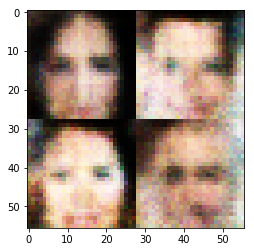

Epoch 1/1... Batch 609/1582... Discriminator Loss: 1.3381... Generator Loss: 0.4236...
Epoch 1/1... Batch 619/1582... Discriminator Loss: 1.2021... Generator Loss: 0.4682...
Epoch 1/1... Batch 629/1582... Discriminator Loss: 1.3315... Generator Loss: 0.4446...
Epoch 1/1... Batch 639/1582... Discriminator Loss: 1.2200... Generator Loss: 0.4275...
Epoch 1/1... Batch 649/1582... Discriminator Loss: 1.3081... Generator Loss: 0.3961...
Epoch 1/1... Batch 659/1582... Discriminator Loss: 1.3784... Generator Loss: 0.4001...
Epoch 1/1... Batch 669/1582... Discriminator Loss: 1.4371... Generator Loss: 0.4902...
Epoch 1/1... Batch 679/1582... Discriminator Loss: 1.3276... Generator Loss: 0.4254...
Epoch 1/1... Batch 689/1582... Discriminator Loss: 1.2409... Generator Loss: 0.4556...
Epoch 1/1... Batch 699/1582... Discriminator Loss: 1.3614... Generator Loss: 0.4274...


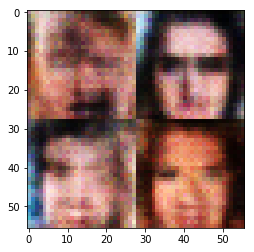

Epoch 1/1... Batch 709/1582... Discriminator Loss: 1.1845... Generator Loss: 0.4468...
Epoch 1/1... Batch 719/1582... Discriminator Loss: 1.3214... Generator Loss: 0.4083...
Epoch 1/1... Batch 729/1582... Discriminator Loss: 1.1752... Generator Loss: 0.4428...
Epoch 1/1... Batch 739/1582... Discriminator Loss: 1.0937... Generator Loss: 0.4328...
Epoch 1/1... Batch 749/1582... Discriminator Loss: 1.3799... Generator Loss: 0.4362...
Epoch 1/1... Batch 759/1582... Discriminator Loss: 1.3364... Generator Loss: 0.4369...
Epoch 1/1... Batch 769/1582... Discriminator Loss: 1.2306... Generator Loss: 0.4267...
Epoch 1/1... Batch 779/1582... Discriminator Loss: 1.2379... Generator Loss: 0.3919...
Epoch 1/1... Batch 789/1582... Discriminator Loss: 1.3226... Generator Loss: 0.4083...
Epoch 1/1... Batch 799/1582... Discriminator Loss: 1.2792... Generator Loss: 0.4245...


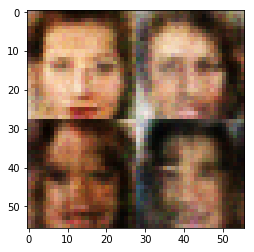

Epoch 1/1... Batch 809/1582... Discriminator Loss: 1.4003... Generator Loss: 0.4474...
Epoch 1/1... Batch 819/1582... Discriminator Loss: 1.3095... Generator Loss: 0.4478...
Epoch 1/1... Batch 829/1582... Discriminator Loss: 1.2230... Generator Loss: 0.4438...
Epoch 1/1... Batch 839/1582... Discriminator Loss: 1.2452... Generator Loss: 0.4454...
Epoch 1/1... Batch 849/1582... Discriminator Loss: 1.2068... Generator Loss: 0.4250...
Epoch 1/1... Batch 859/1582... Discriminator Loss: 1.3109... Generator Loss: 0.4297...
Epoch 1/1... Batch 869/1582... Discriminator Loss: 1.2633... Generator Loss: 0.4321...
Epoch 1/1... Batch 879/1582... Discriminator Loss: 1.2263... Generator Loss: 0.4239...
Epoch 1/1... Batch 889/1582... Discriminator Loss: 1.2771... Generator Loss: 0.4261...
Epoch 1/1... Batch 899/1582... Discriminator Loss: 1.2351... Generator Loss: 0.4127...


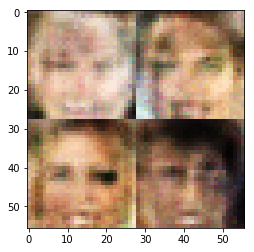

Epoch 1/1... Batch 909/1582... Discriminator Loss: 1.2285... Generator Loss: 0.4351...
Epoch 1/1... Batch 919/1582... Discriminator Loss: 1.2270... Generator Loss: 0.3909...
Epoch 1/1... Batch 929/1582... Discriminator Loss: 1.1839... Generator Loss: 0.4403...
Epoch 1/1... Batch 939/1582... Discriminator Loss: 1.2193... Generator Loss: 0.3908...
Epoch 1/1... Batch 949/1582... Discriminator Loss: 1.1278... Generator Loss: 0.5120...
Epoch 1/1... Batch 959/1582... Discriminator Loss: 1.1379... Generator Loss: 0.4531...
Epoch 1/1... Batch 969/1582... Discriminator Loss: 1.2009... Generator Loss: 0.4262...
Epoch 1/1... Batch 979/1582... Discriminator Loss: 1.1241... Generator Loss: 0.4650...
Epoch 1/1... Batch 989/1582... Discriminator Loss: 1.1444... Generator Loss: 0.4497...
Epoch 1/1... Batch 999/1582... Discriminator Loss: 1.2331... Generator Loss: 0.4004...


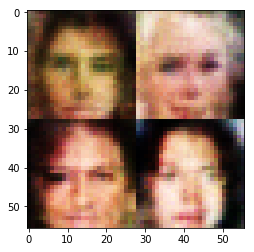

Epoch 1/1... Batch 1009/1582... Discriminator Loss: 1.1483... Generator Loss: 0.5123...
Epoch 1/1... Batch 1019/1582... Discriminator Loss: 1.1896... Generator Loss: 0.4108...
Epoch 1/1... Batch 1029/1582... Discriminator Loss: 1.2210... Generator Loss: 0.4016...
Epoch 1/1... Batch 1039/1582... Discriminator Loss: 1.1490... Generator Loss: 0.4193...
Epoch 1/1... Batch 1049/1582... Discriminator Loss: 1.1750... Generator Loss: 0.4526...
Epoch 1/1... Batch 1059/1582... Discriminator Loss: 1.1072... Generator Loss: 0.4552...
Epoch 1/1... Batch 1069/1582... Discriminator Loss: 1.2340... Generator Loss: 0.4126...
Epoch 1/1... Batch 1079/1582... Discriminator Loss: 1.2224... Generator Loss: 0.4314...
Epoch 1/1... Batch 1089/1582... Discriminator Loss: 1.2629... Generator Loss: 0.4062...
Epoch 1/1... Batch 1099/1582... Discriminator Loss: 1.2309... Generator Loss: 0.4611...


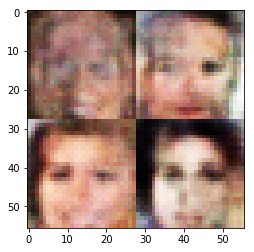

Epoch 1/1... Batch 1109/1582... Discriminator Loss: 1.1901... Generator Loss: 0.4391...
Epoch 1/1... Batch 1119/1582... Discriminator Loss: 1.2590... Generator Loss: 0.3779...
Epoch 1/1... Batch 1129/1582... Discriminator Loss: 1.2331... Generator Loss: 0.4144...
Epoch 1/1... Batch 1139/1582... Discriminator Loss: 1.3405... Generator Loss: 0.3657...
Epoch 1/1... Batch 1149/1582... Discriminator Loss: 1.3415... Generator Loss: 0.3679...
Epoch 1/1... Batch 1159/1582... Discriminator Loss: 1.2981... Generator Loss: 0.4167...
Epoch 1/1... Batch 1169/1582... Discriminator Loss: 1.3690... Generator Loss: 0.4437...
Epoch 1/1... Batch 1179/1582... Discriminator Loss: 1.2329... Generator Loss: 0.4068...
Epoch 1/1... Batch 1189/1582... Discriminator Loss: 1.2784... Generator Loss: 0.4547...
Epoch 1/1... Batch 1199/1582... Discriminator Loss: 1.4292... Generator Loss: 0.4621...


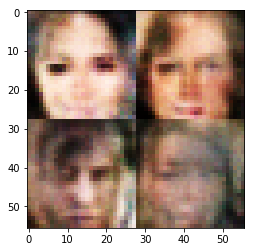

Epoch 1/1... Batch 1209/1582... Discriminator Loss: 1.2871... Generator Loss: 0.4133...
Epoch 1/1... Batch 1219/1582... Discriminator Loss: 1.2525... Generator Loss: 0.3927...
Epoch 1/1... Batch 1229/1582... Discriminator Loss: 1.3234... Generator Loss: 0.4177...
Epoch 1/1... Batch 1239/1582... Discriminator Loss: 1.3514... Generator Loss: 0.4773...
Epoch 1/1... Batch 1249/1582... Discriminator Loss: 1.3974... Generator Loss: 0.4458...
Epoch 1/1... Batch 1259/1582... Discriminator Loss: 1.4235... Generator Loss: 0.3165...
Epoch 1/1... Batch 1269/1582... Discriminator Loss: 1.3283... Generator Loss: 0.4628...
Epoch 1/1... Batch 1279/1582... Discriminator Loss: 1.3322... Generator Loss: 0.4156...
Epoch 1/1... Batch 1289/1582... Discriminator Loss: 1.3313... Generator Loss: 0.4055...
Epoch 1/1... Batch 1299/1582... Discriminator Loss: 1.3431... Generator Loss: 0.3800...


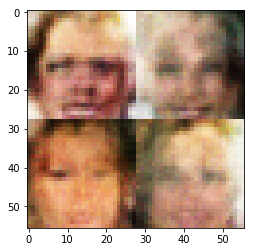

Epoch 1/1... Batch 1309/1582... Discriminator Loss: 1.3671... Generator Loss: 0.4484...
Epoch 1/1... Batch 1319/1582... Discriminator Loss: 1.3289... Generator Loss: 0.4030...
Epoch 1/1... Batch 1329/1582... Discriminator Loss: 1.4266... Generator Loss: 0.4013...
Epoch 1/1... Batch 1339/1582... Discriminator Loss: 1.4084... Generator Loss: 0.4372...
Epoch 1/1... Batch 1349/1582... Discriminator Loss: 1.4446... Generator Loss: 0.4250...
Epoch 1/1... Batch 1359/1582... Discriminator Loss: 1.4849... Generator Loss: 0.3247...
Epoch 1/1... Batch 1369/1582... Discriminator Loss: 1.4031... Generator Loss: 0.4175...
Epoch 1/1... Batch 1379/1582... Discriminator Loss: 1.4559... Generator Loss: 0.4426...
Epoch 1/1... Batch 1389/1582... Discriminator Loss: 1.4720... Generator Loss: 0.3269...
Epoch 1/1... Batch 1399/1582... Discriminator Loss: 1.3855... Generator Loss: 0.4265...


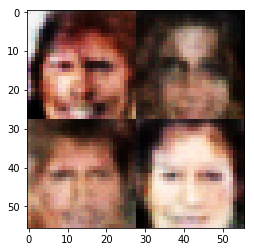

Epoch 1/1... Batch 1409/1582... Discriminator Loss: 1.3938... Generator Loss: 0.3978...
Epoch 1/1... Batch 1419/1582... Discriminator Loss: 1.2316... Generator Loss: 0.4219...
Epoch 1/1... Batch 1429/1582... Discriminator Loss: 1.4070... Generator Loss: 0.4478...
Epoch 1/1... Batch 1439/1582... Discriminator Loss: 1.2654... Generator Loss: 0.4278...
Epoch 1/1... Batch 1449/1582... Discriminator Loss: 1.3466... Generator Loss: 0.4098...
Epoch 1/1... Batch 1459/1582... Discriminator Loss: 1.4485... Generator Loss: 0.4007...
Epoch 1/1... Batch 1469/1582... Discriminator Loss: 1.3532... Generator Loss: 0.4375...
Epoch 1/1... Batch 1479/1582... Discriminator Loss: 1.3401... Generator Loss: 0.4113...
Epoch 1/1... Batch 1489/1582... Discriminator Loss: 1.3625... Generator Loss: 0.3957...
Epoch 1/1... Batch 1499/1582... Discriminator Loss: 1.3746... Generator Loss: 0.4436...


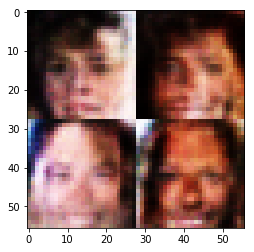

Epoch 1/1... Batch 1509/1582... Discriminator Loss: 1.3471... Generator Loss: 0.4299...
Epoch 1/1... Batch 1519/1582... Discriminator Loss: 1.3804... Generator Loss: 0.4154...
Epoch 1/1... Batch 1529/1582... Discriminator Loss: 1.3415... Generator Loss: 0.4104...
Epoch 1/1... Batch 1539/1582... Discriminator Loss: 1.3654... Generator Loss: 0.3927...
Epoch 1/1... Batch 1549/1582... Discriminator Loss: 1.4642... Generator Loss: 0.3963...
Epoch 1/1... Batch 1559/1582... Discriminator Loss: 1.3553... Generator Loss: 0.4075...
Epoch 1/1... Batch 1569/1582... Discriminator Loss: 1.3694... Generator Loss: 0.4139...
Epoch 1/1... Batch 1579/1582... Discriminator Loss: 1.5005... Generator Loss: 0.3794...


In [18]:
batch_size = 128
z_dim = 64
learning_rate = 0.0001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.